#Imports

In [8]:
import os
import json
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer

#Loading and Checking Data

In [9]:
data_dir = "/content/train_tweets"
all_data = []
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        df_temp = pd.read_csv(os.path.join(data_dir, filename))
        all_data.append(df_temp)

df = pd.concat(all_data, ignore_index=True)

print("Data shape:", df.shape)
print(df.head())

Data shape: (5056050, 6)
    ID  MatchID  PeriodID  EventType      Timestamp  \
0  1_0        1         0          0  1404849000000   
1  1_0        1         0          0  1404849000000   
2  1_0        1         0          0  1404849000000   
3  1_0        1         0          0  1404849000000   
4  1_0        1         0          0  1404849000000   

                                               Tweet  
0  RT @RMadridHome: Sami Khedira is starting for ...  
1  RT @Yohanyx3: Damn half of ya saying go brazil...  
2  Colombia should be the ones playing against Ge...  
3  RT @tonyrizk_963: The Injury list :\nFrom #BRA...  
4  Brazil should still be favored vs. Germany—if ...  


#Missing values, Duplicates, and Info

In [10]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Drop duplicates if any
df.drop_duplicates(inplace=True)

# Quick info
print(df.info())

Missing values:
 ID           0
MatchID      0
PeriodID     0
EventType    0
Timestamp    0
Tweet        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 4638243 entries, 0 to 5056049
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   ID         object
 1   MatchID    int64 
 2   PeriodID   int64 
 3   EventType  int64 
 4   Timestamp  int64 
 5   Tweet      object
dtypes: int64(4), object(2)
memory usage: 247.7+ MB
None


#Distribution of EventType


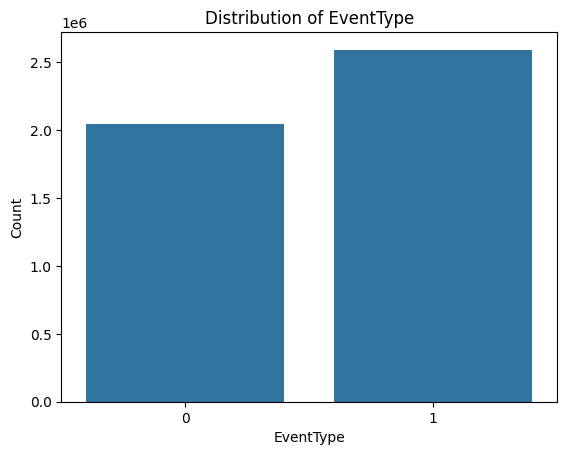

Class distribution:
 EventType
1    2590973
0    2047270
Name: count, dtype: int64


In [11]:
event_counts = df['EventType'].value_counts()
sns.barplot(x=event_counts.index, y=event_counts.values)
plt.title("Distribution of EventType")
plt.xlabel("EventType")
plt.ylabel("Count")
plt.show()

print("Class distribution:\n", event_counts)

#Distribution of PeriodIDs and Event probabilities



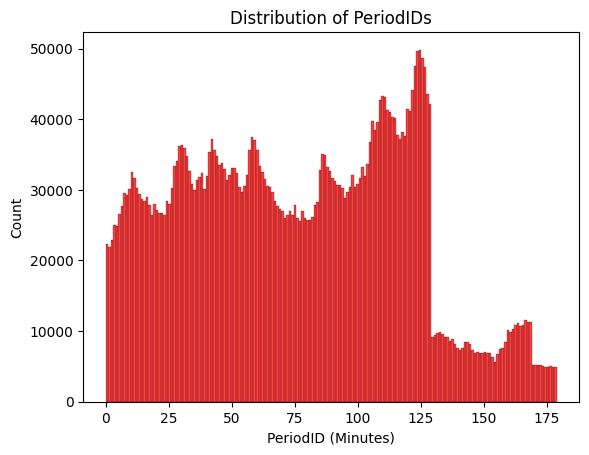

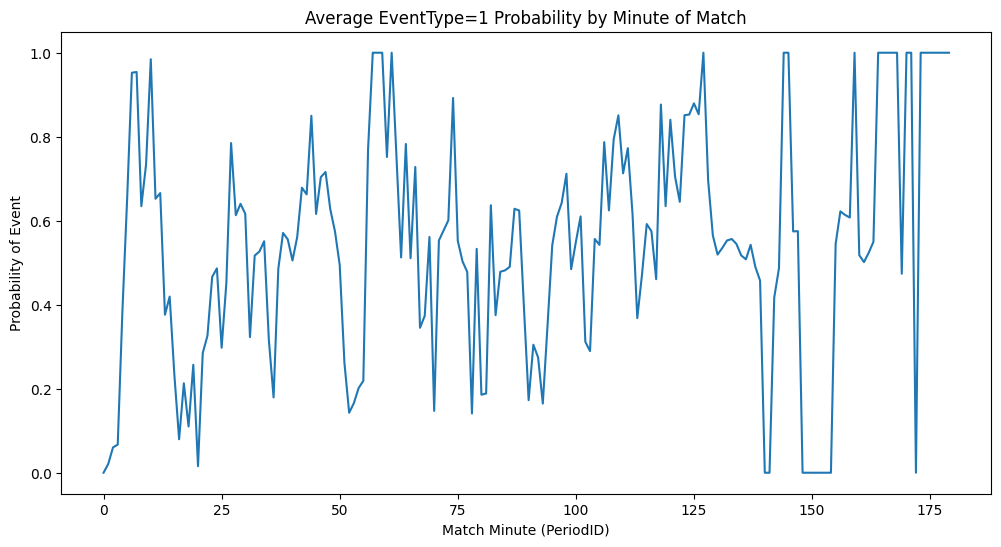

In [12]:
# Get the number of unique PeriodIDs
num_bins = df['PeriodID'].nunique()

# Distribution of PeriodID
sns.histplot(df['PeriodID'], kde=False, bins=num_bins, color='red')  # Dynamically set bins
plt.title("Distribution of PeriodIDs")
plt.xlabel("PeriodID (Minutes)")
plt.ylabel("Count")
plt.show()

# Average probability of event by minute across matches
minute_event_rate = df.groupby('PeriodID')['EventType'].mean()
plt.figure(figsize=(12, 6))
minute_event_rate.plot(kind='line')
plt.title("Average EventType=1 Probability by Minute of Match")
plt.xlabel("Match Minute (PeriodID)")
plt.ylabel("Probability of Event")
plt.show()


# Matches by Event Rate


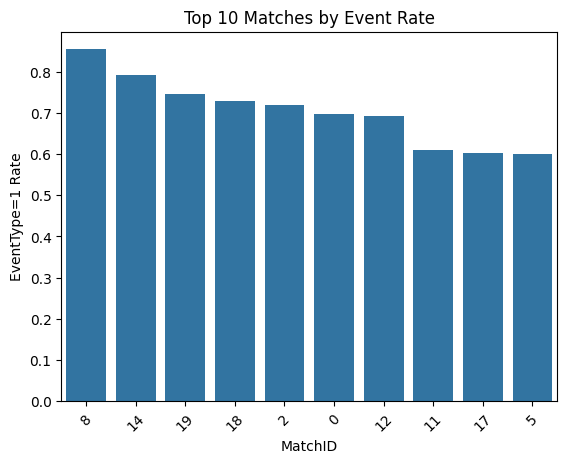

In [13]:
match_event_rate = df.groupby('MatchID')['EventType'].mean().sort_values(ascending=False)
top_10_matches = match_event_rate.head(10)
sns.barplot(x=top_10_matches.index.astype(str), y=top_10_matches.values)
plt.title("Top 10 Matches by Event Rate")
plt.xlabel("MatchID")
plt.ylabel("EventType=1 Rate")
plt.xticks(rotation=45)
plt.show()

# Differences Between Classes

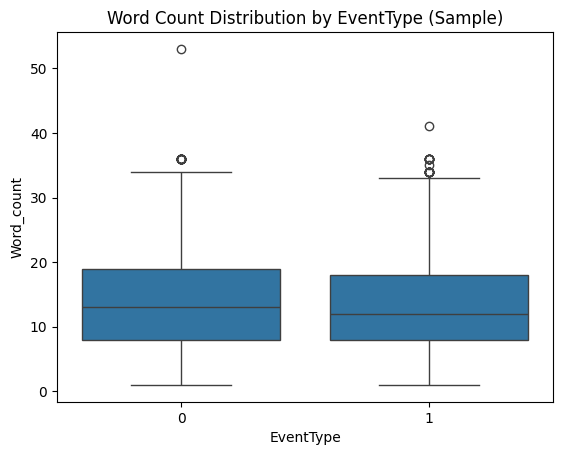

In [14]:
sample_fraction = 0.1
df_sample = df.sample(frac=sample_fraction, random_state=42)
df_sample['Tweet_length'] = df_sample['Tweet'].astype(str).apply(len)
df_sample['Word_count'] = df_sample['Tweet'].astype(str).apply(lambda x: len(x.split()))

sns.boxplot(x='EventType', y='Word_count', data=df_sample)
plt.title("Word Count Distribution by EventType (Sample)")
plt.show()

# Keyword Count

## Data Preprocessing

In [15]:
import bisect
import os
import re
import gensim.downloader as api
import nltk
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from nltk.stem import PorterStemmer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [17]:
nltk.download('stopwords')
nltk.download('wordnet')

if not os.path.exists("glove-twitter-200.model"):
    embeddings_model = api.load("glove-twitter-200")
    embeddings_model.save("glove-twitter-200.model")
else:
    embeddings_model = KeyedVectors.load("glove-twitter-200.model")

vector_size = 200

stopwords_list = []
with open("stop_words.txt", 'r', encoding='utf-8') as f:
    for line in f:
        w = line.strip()
        if w:
            stopwords_list.append(w)
stopwords_list = sorted(stopwords_list)
stemmer = PorterStemmer()

# Define a list of event-related keywords to count.
# You can refine this list based on domain knowledge.
keywords = [
    'goal', 'score', 'kick', 'penalti', 'card',
    'half', 'time', 'red', 'yellow', 'own', 'full'
]

def contains_url(tweet):
    return len(re.findall(r"http[s]?\S+", tweet)) != 0

def is_retweet(tweet):
    return len(re.findall(r"rt @?[a-zA-Z0-9_]+:? .*", tweet)) != 0

def contains_username(tweet):
    return '@' in tweet

def preprocess_tweet(tweet):
    tweet = tweet.lower().strip()

    if contains_url(tweet):
        return None

    if is_retweet(tweet):
        return None

    if contains_username(tweet):
        return None

    tweet = re.sub(r'\W+', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    if not tweet:
        return None

    words = []
    for word in tweet.split(" "):
        pos = bisect.bisect(stopwords_list, word)
        if pos > 0 and stopwords_list[pos - 1] == word:
            continue
        words.append(word)

    if not words:
        return None

    words = [stemmer.stem(w) for w in words]

    if not words:
        return None

    return ' '.join(words)

def get_avg_embedding(tweet, model, vector_size=200):
    words = tweet.split()
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

def count_keywords(tweet, keywords):
    """
    Count how many times each keyword appears in the processed tweet.
    """
    if tweet is None:
        return {kw: 0 for kw in keywords}
    words = tweet.split()
    counts = {kw: 0 for kw in keywords}
    for w in words:
        if w in counts:
            counts[w] += 1
    return counts


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# Load training data
li = []
for filename in os.listdir("/content/train_tweets"):
    train_df = pd.read_csv(os.path.join("/content/train_tweets", filename))
    li.append(train_df)
train_df = pd.concat(li, ignore_index=True)

# Preprocess tweets
train_df['Tweet'] = train_df['Tweet'].apply(preprocess_tweet)
train_df = train_df[train_df['Tweet'].notna()].copy()
train_df = train_df.reset_index(drop=True)

# Count keyword occurrences for each tweet
train_df['KeywordCount'] = train_df['Tweet'].apply(lambda x: sum(count_keywords(x, keywords).values()))

# Get tweet embeddings
tweet_vectors = np.vstack([get_avg_embedding(tweet, embeddings_model, vector_size) for tweet in train_df['Tweet']])
tweet_df = pd.DataFrame(tweet_vectors)

# Combine embeddings with original features
period_features = pd.concat([train_df, tweet_df], axis=1)

# Now, when grouping by period, we can sum up the KeywordCount
period_features = period_features.drop(columns=['Timestamp', 'Tweet'])
period_features = period_features.groupby(['MatchID', 'PeriodID', 'ID'], as_index=False).agg({
    'EventType': 'median',
    'KeywordCount': 'sum',
    **{col:'median' for col in tweet_df.columns}  # median of embedding features
})

X = period_features.drop(columns=['EventType', 'MatchID', 'PeriodID', 'ID']).values
y = period_features['EventType'].values.astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)


## Plots

### Data for maximum number of peroids in our matches. Only two of them last longer then 129 min.

In [20]:
max_period_per_match = period_features.groupby('MatchID')['PeriodID'].max()

print(max_period_per_match)

MatchID
0     129
1     129
2     129
3     129
4     169
5     129
7     129
8     129
10    179
11    129
12     96
13    129
14    129
17    129
18    129
19    129
Name: PeriodID, dtype: int64


### Checking Balance of Classes

In [21]:
period_features['EventType'].value_counts()

,count
EventType,
1.0,1153
0.0,984


### Distribution of Keyword Counts by period and event type

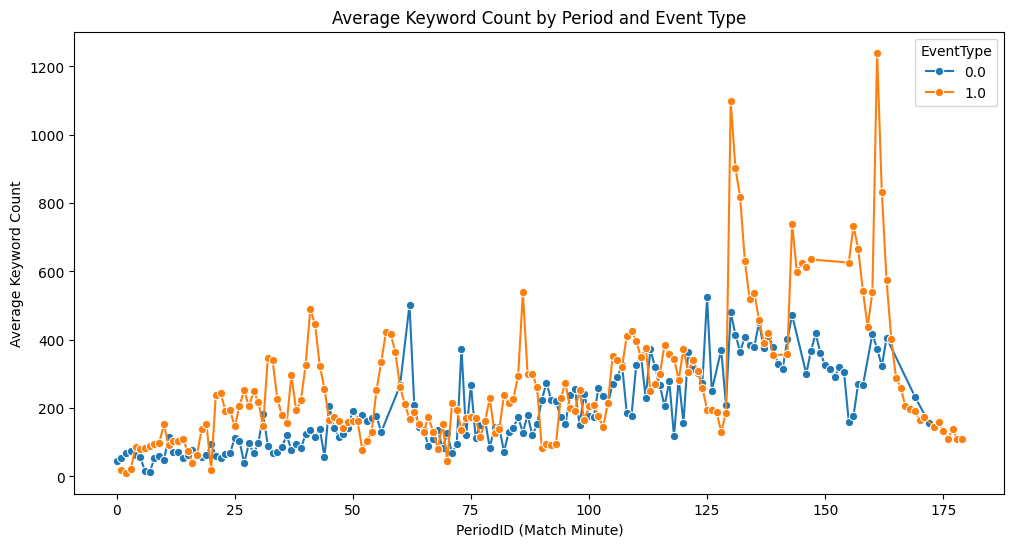

In [22]:
df_plot = period_features.groupby(['PeriodID', 'EventType'])['KeywordCount'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='PeriodID', y='KeywordCount', hue='EventType', data=df_plot, marker='o')
plt.title("Average Keyword Count by Period and Event Type")
plt.xlabel("PeriodID (Match Minute)")
plt.ylabel("Average Keyword Count")
plt.legend(title="EventType")
plt.show()